In [26]:
from lcs.agents.facs2 import fACS2, Configuration
from lcs.agents.facs2.adapters.WoodsFuzzyEnvironmentAdapter import WoodsFuzzyEnvironmentAdapter
from lcs.agents.facs2.adapters.Mazev2FuzzyEnvironmentAdapter import Mazev2FuzzyEnvironmentAdapter
from lcs.metrics import population_metrics
import gym
import gym_maze
import gym_woods
import logging

import pandas as pd
import numpy as np
from scipy.misc import face

logging.basicConfig(level=logging.INFO)

def knowledge(population, environment) -> float:
    transitions = environment.env.get_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:

        p0 = environment.env.maze.perception(start)
        p1 = environment.env.maze.perception(end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)# * 100.0


def basic_metrics(agent, env):
    pop = agent.population
    metrics = population_metrics(pop, env)
    return metrics

def knowledge_metrics(agent, env):
    pop = agent.population
    metrics = {
        'knowledge': knowledge(pop, env)
    }

    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

cfg_lin_2 = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    epsilon=0.9,
    user_metrics_collector_fcn=basic_metrics,
    aggregation_method='sum_to_two',
    fuzzy_function='linear',
    do_ga=True
    )

cfg_lin_3 = Configuration(
    classifier_length=9,#Mazev2FuzzyEnvironmentAdapter.condition_length,
    number_of_possible_actions=8,
    epsilon=0.9,
    user_metrics_collector_fcn=basic_metrics,
    aggregation_method='sum_to_three',
    fuzzy_function='linear',
    do_ga=True
    )

cfg_sig_2 = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    epsilon=0.9,
    user_metrics_collector_fcn=basic_metrics,
    aggregation_method='sum_to_two',
    #theta_r=0.1,
    fuzzy_function='sigmoid',
    do_ga=True
    )

cfg_sig_3 = Configuration(
    classifier_length=9,#WoodsFuzzyEnvironmentAdapter.condition_length,
    number_of_possible_actions=8,
    epsilon=0.9,
    user_metrics_collector_fcn=basic_metrics,
    aggregation_method='sum_to_three',
    fuzzy_function='sigmoid',
    do_ga=True
    )


environment_name = 'Woods14-v0'
env = WoodsFuzzyEnvironmentAdapter(gym.make(environment_name))

env.reset()
env.render()

trial = 150
repeats = 10



■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ □ □ □ ■ ■ ■ ■ □ ■ ■ □ ■
■ □ ■ ■ ■ X ■ ■ □ ■ □ ■ □ ■
■ □ ■ ■ ■ □ ■ □ ■ ■ ■ □ ■ ■
■ $ ■ ■ ■ □ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ □ □ ■ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


In [27]:
def calculate_step_mean(arr, step:int=3):
    len = arr.size-1
    new_arr = []
    new_arr.append(arr[0])
    for i in range(1,len): 
        #print(arr[i-1:i+2:1])   
        new_arr.append(np.mean(arr[i-1:i+2:1]))

    new_arr.append(arr[-1])
    return new_arr

#calculate_step_mean(np.array([1,2,10,3,4,7,15,2,8]))

In [28]:
def make_experiment(cfg, env, trial, repeats):
    logging.basicConfig(level=logging.INFO)
    agent = fACS2(cfg)

    
    env.reset()
    env.render()

    gen_pop = []#np.array([])
    gen_rel = []#np.array([])

    for i in range(repeats):
        pop = []
        rel = []
        agent_explore = agent.explore(env, trial)

        print(agent_explore)

        for j in range(trial):
            pop.append(agent_explore[j]['population'])
            rel.append(agent_explore[j]['reliable'])

        pop = np.array(pop)
        rel = np.array(rel)

        pop = calculate_step_mean(pop)
        rel = calculate_step_mean(rel)

        gen_pop.append(pop)
        gen_rel.append(rel)

        logging.info(f'Repeats {i} of {repeats-1}')
        #print(f'Repeats {i} of {repeats}')

    return np.array(gen_pop).mean(axis=0), np.array(gen_rel).mean(axis=0)

    #gen_pop_mean_lin_2 = np.array(gen_pop).mean(axis=0)
    #gen_rel_mean_lin_2 = np.array(gen_rel).mean(axis=0)

In [ ]:
pop_lin_2, rel_lin_2 = make_experiment(cfg_lin_2,env,150,10)
#pop_lin_2 = np.load('pop_lin_2.npy')
#rel_lin_2 = np.load('rel_lin_2.npy')

In [ ]:
pop_lin_3, rel_lin_3 = make_experiment(cfg_lin_3,env,150,10)
#pop_lin_3 = np.load('pop_lin_3.npy')
#rel_lin_3 = np.load('rel_lin_3.npy')

In [ ]:
pop_sig_2, rel_sig_2 = make_experiment(cfg_sig_2,env,150,10)
#pop_sig_2 = np.load('pop_sig_2.npy')
#rel_sig_2 = np.load('rel_sig_2.npy')

In [ ]:
pop_sig_3, rel_sig_3 = make_experiment(cfg_sig_3,env,150,10)
#pop_sig_3 = np.load('pop_sig_3.npy')
#rel_sig_3 = np.load('rel_sig_3.npy')

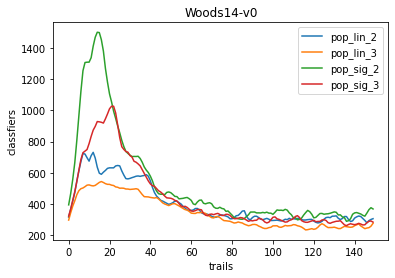

In [34]:
import matplotlib.pyplot as plt
linspace = np.arange(0,150,1)
plt.title(environment_name)
plt.xlabel('trails')
plt.ylabel('classfiers')
plt.plot(linspace,pop_lin_2,label="pop_lin_2")
plt.plot(linspace,pop_lin_3,label="pop_lin_3")
plt.plot(linspace,pop_sig_2,label="pop_sig_2")
plt.plot(linspace,pop_sig_3,label="pop_sig_3")

plt.legend(loc="upper right")
plt.show()

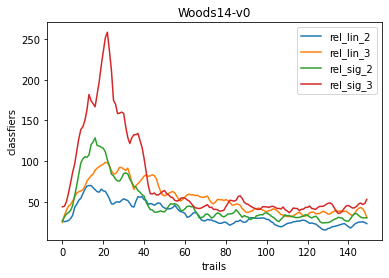

In [35]:
plt.title(environment_name)
plt.xlabel('trails')
plt.ylabel('classfiers')
plt.plot(linspace,rel_lin_2,label="rel_lin_2")
plt.plot(linspace,rel_lin_3,label="rel_lin_3")
plt.plot(linspace,rel_sig_2,label="rel_sig_2")
plt.plot(linspace,rel_sig_3,label="rel_sig_3")

plt.legend(loc="upper right")
plt.show()

# Podpisać osie.
# Tytuł wykresu - środowisko.

# Metryka knowledge - sprawdzić i zaimplementować (w artykule było) 
# W labiryncie
# % klasyfikatorów opisuje 
# Wykres knowledge 

# Przeprowadzić eksperymenty dla innych środowisk np. Maze5, Woods


In [36]:
np.save('./data/Woods14/rel_lin_2.npy', rel_lin_2)
np.save('./data/Woods14/rel_lin_3.npy', rel_lin_3)
np.save('./data/Woods14/rel_sig_2.npy', rel_sig_2)
np.save('./data/Woods14/rel_sig_3.npy', rel_sig_3)



In [37]:
np.save('./data/Woods14/pop_lin_2.npy', pop_lin_2)
np.save('./data/Woods14/pop_lin_3.npy', pop_lin_3)
np.save('./data/Woods14/pop_sig_2.npy', pop_sig_2)
np.save('./data/Woods14/pop_sig_3.npy', pop_sig_3)